<a href="https://colab.research.google.com/github/rushikamod28/Diabetic_Retinopathy_Detection_using_Deep_Learning/blob/main/Diabetic_Retinopathy_Detection_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
!pip install "dask==2025.5.0" "fsspec" "datasets" --upgrade --quiet

In [ ]:
import io
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
base_url = "hf://datasets/youssefedweqd/Diabetic_Retinopathy_Detection_preprocessed2/"
splits = {
    'train': 'data/train-*.parquet',
    'validation': 'data/validation-00000-of-00001.parquet',
    'test': 'data/test-*.parquet'
}

df_train = dd.read_parquet(base_url + splits["train"]).compute()
df_val = dd.read_parquet(base_url + splits["validation"]).compute()
df_test = dd.read_parquet(base_url + splits["test"]).compute()

print("Train size:", len(df_train))
print("Validation size:", len(df_val))
print("Test size:", len(df_test))
print("Train labels:", Counter(df_train['label']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train size: 25290
Validation size: 2810
Test size: 7026
Train labels: Counter({0: 18583, 2: 3811, 1: 1759, 3: 628, 4: 509})


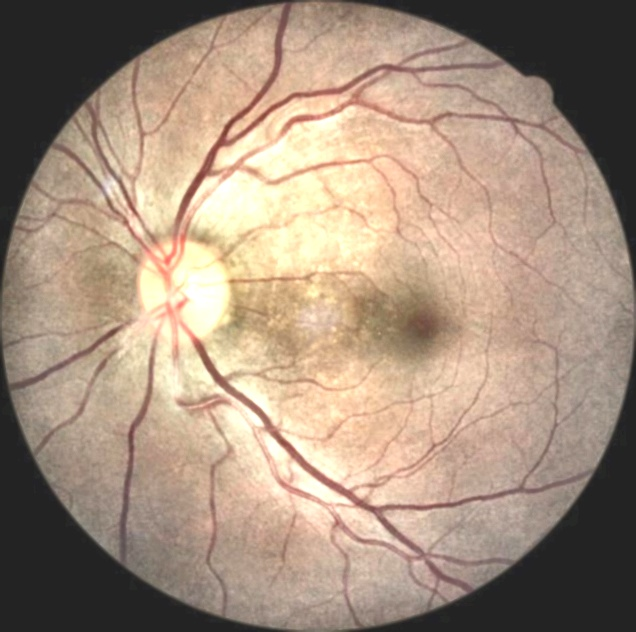

In [ ]:
# sample image
img_dict = df_train.iloc[0]['image']; display(Image.open(io.BytesIO(img_dict['bytes'])))

In [ ]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 5

In [ ]:
def image_generator(df):
    for i in range(len(df)):
        img_bytes = df.iloc[i]['image']['bytes']
        label = int(df.iloc[i]['label'])
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        img = img.resize(IMG_SIZE)
        arr = np.array(img, dtype=np.float32) / 255.0
        yield arr, label

def make_dataset(df, shuffle=True):
    ds = tf.data.Dataset.from_generator(
        lambda: image_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(df_train)
val_ds = make_dataset(df_val, shuffle=False)
test_ds = make_dataset(df_test, shuffle=False)


In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# callbacks for early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint("dr_rgb_best.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

In [ ]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/5
    791/Unknown 310s 349ms/step - accuracy: 0.9772 - loss: 0.0717

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.70654, saving model to dr_rgb_best.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 352s 402ms/step - accuracy: 0.9771 - loss: 0.0720 - val_accuracy: 0.1505 - val_loss: 1.7065
Epoch 2/5
790/791 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6082 - loss: 1.1618
Epoch 2: val_loss improved from 1.70654 to 1.20228, saving model to dr_rgb_best.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 304s 372ms/step - accuracy: 0.6083 - loss: 1.1615 - val_accuracy: 0.7349 - val_loss: 1.2023
Epoch 3/5
789/791 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9610 - loss: 0.7454
Epoch 3: val_loss improved from 1.20228 to 1.07320, saving model to dr_rgb_best.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 322s 372ms/step - accuracy: 0.9602 - loss: 0.7458 - val_accuracy: 0.7349 - val_loss: 1.0732
Epoch 4/5
789/791 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9604 - loss: 0.6628
Epoch 4: val_loss improved from 1.07320 to 0.99501, saving model to dr_rgb_best.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 321s 371ms/step - accuracy: 0.9595 - loss: 0.6636 - val_accuracy: 0.7349 - val_loss: 0.9950
Epoch 5/5
789/791 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9605 - loss: 0.6397
Epoch 5: val_loss improved from 0.99501 to 0.91768, saving model to dr_rgb_best.h5


791/791 ━━━━━━━━━━━━━━━━━━━━ 321s 369ms/step - accuracy: 0.9596 - loss: 0.6409 - val_accuracy: 0.7349 - val_loss: 0.9177


In [ ]:
# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 365ms/step - accuracy: 0.9591 - loss: 0.5843
Test Accuracy: 0.7347


In [ ]:
# Save model
model.save("dr_final.h5")
print("Saved model: dr_final.h5")

Saved model: dr_final.h5


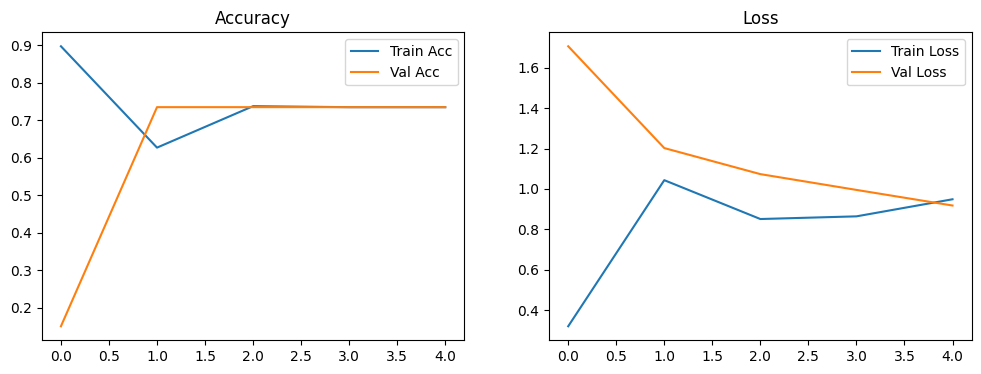

In [ ]:
# Plot accuracy or loss curve
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()